# **Problem**

Tumours vary significantly in size, shape, and texture, making accurate segmentation difficult for both traditional methods and humans. The data imbalance, especially where tumours occupy only a small portion of the image, often leads models to overlook these regions. Manual segmentation is labour-intensive and highly reliant on the radiologist expertise which can become inefficient with increasing data volume. Furthermore, ensuring that a model can generalize well across different modalities such as MRI and ultrasound adds complexity due to the variability in these techniques. These challenges need to be solved through an automated system capable of efficient and accurate segmentation across diverse imaging datasets.

Objective

My primary object in this project was to create a U-Net-based deep learning model that could accurately and efficiently segment breast cancer tumours from medical images, which in turn can assist radiologists by speeding up the diagnostics and improving the tumour detection accuracy. To archive this, I focused upon optimizing the model’s performance for small or irregularly shaped tumours, by maximizing the Dice Coefficient and IoU. Addressing the data imbalance, I incorporated a combined loss function (Binary Cross-Entropy and Dice loss) to ensure that the small tumours were not overlooked. I also aim to improve the generalization by applying data augmentation techniques such as flipping, rotation and scaling to ensure the model could handle different imaging modalities. Furthermore, the model should be able to show the models performance through comparing the predicted masks alongside the actual image for assessment.

# Data Collection

Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Importing Kaggle Dataset 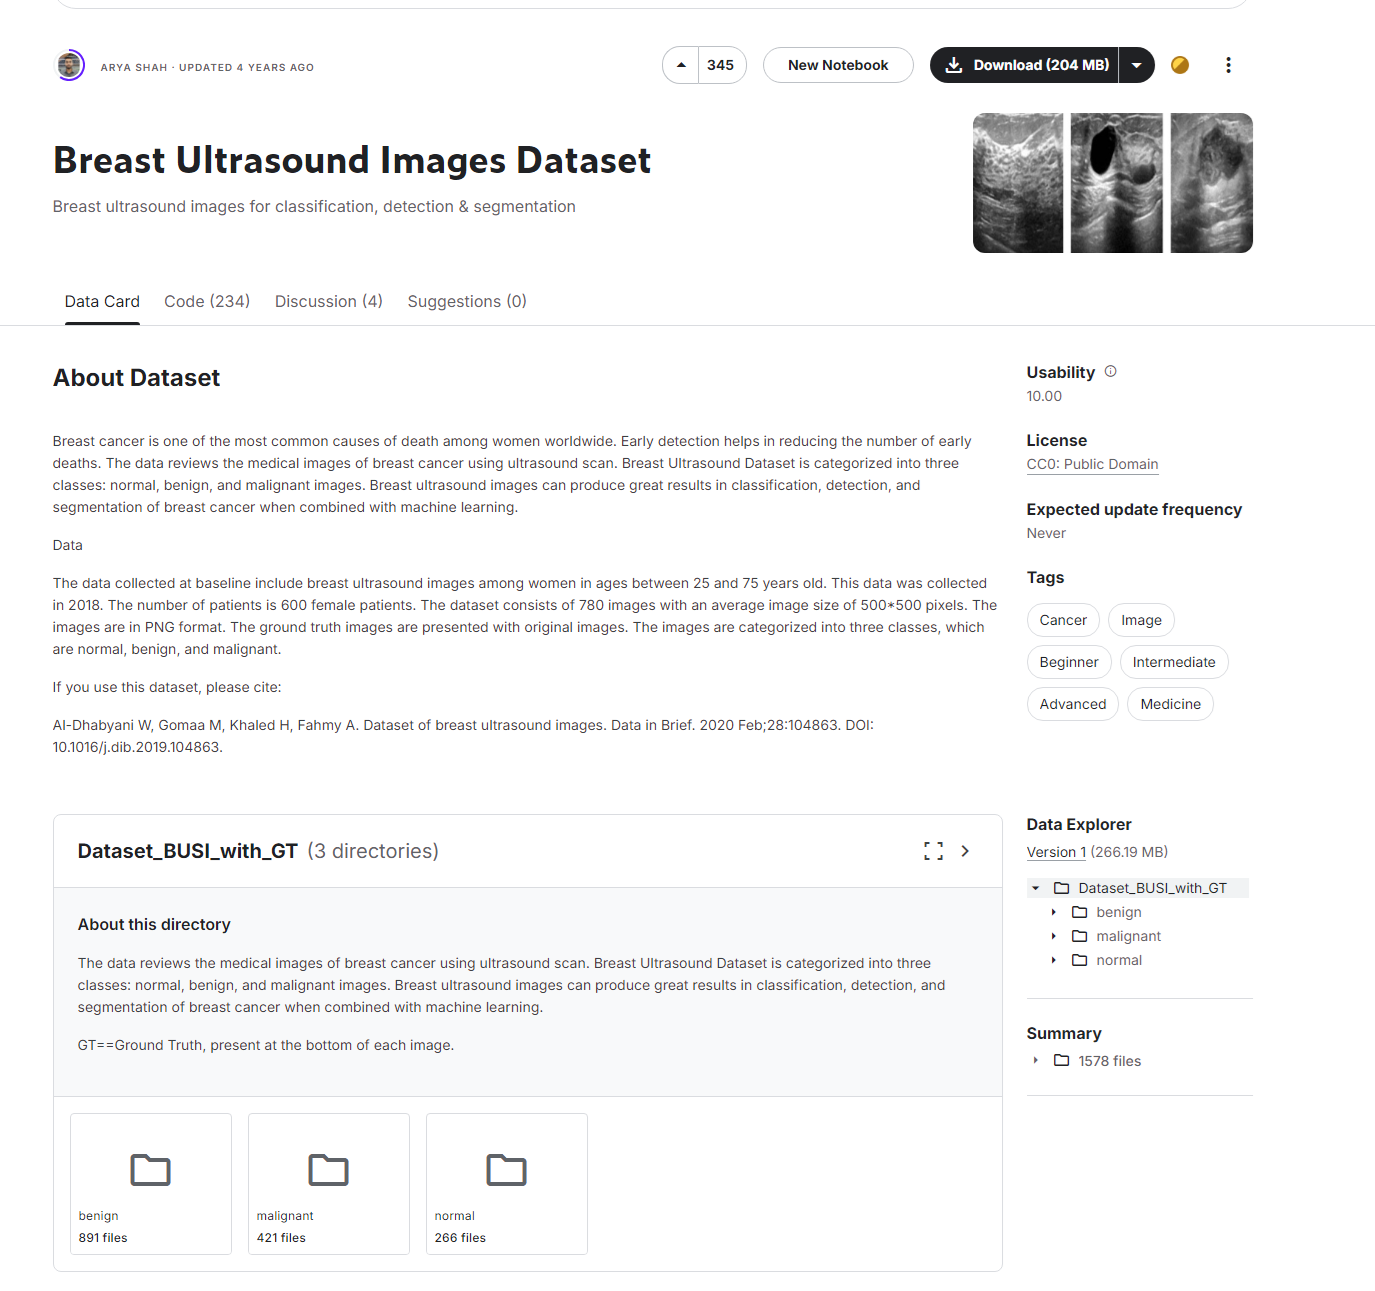

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 90% 175M/195M [00:00<00:00, 254MB/s]
100% 195M/195M [00:00<00:00, 252MB/s]


In [ ]:
!unzip /content/breast-ultrasound-images-dataset.zip

Archive:  /content/breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflat

# Data Preprocessing

Seperate the data sets from the images and masks

In [ ]:
import os
import shutil

# Paths to the dataset directories
dataset_path = "/content/Dataset_BUSI_with_GT"
mask_output_dir = "/content/data/masks"
image_output_dir = "/content/data/img"

# Create the mask and image directories if they don't exist
os.makedirs(mask_output_dir, exist_ok=True)
os.makedirs(image_output_dir, exist_ok=True)

# Function to separate mask files and image files
def separate_files(directory, mask_output_dir, image_output_dir):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if "_mask" in file:
                # This is a mask file
                src = os.path.join(root, file)
                dst = os.path.join(mask_output_dir, file)
                shutil.move(src, dst)
            else:
                # This is an image file
                src = os.path.join(root, file)
                dst = os.path.join(image_output_dir, file)
                shutil.move(src, dst)

# Separate files for benign, malignant, and normal directories
categories = ['benign', 'malignant', 'normal']
for category in categories:
    category_path = os.path.join(dataset_path, category)
    separate_files(category_path, mask_output_dir, image_output_dir)

print("Files have been separated successfully!")


Files have been separated successfully!


# Setting up of environment

Move files to a more common directory

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # RGB
MASK_CHANNELS = 1  # Grayscale

# Paths
IMAGE_DIR = '/content/data/img'
MASK_DIR = '/content/data/masks'
# Correct the file extension for saving weights
MODEL_SAVE_PATH = '/content/models/unet_best_weights.weights.h5'


Load data to prepare for training

In [ ]:
def load_data(image_dir, mask_dir, img_height, img_width, num_samples=None):
    # List and sort files
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Ensure that masks are paired based on a naming convention
    image_base_names = [os.path.splitext(f)[0] for f in image_files]  # Remove file extensions for matching
    mask_base_names = [os.path.splitext(f)[0].replace('_mask', '') for f in
                       mask_files]  # Assume '_mask' is part of mask names

    if num_samples:
        # Randomly sample num_samples files
        selected_indices = random.sample(range(len(image_files)), num_samples)
        selected_image_files = [image_files[i] for i in selected_indices]
        selected_image_base_names = [image_base_names[i] for i in selected_indices]
    else:
        # Use all available files
        selected_image_files = image_files
        selected_image_base_names = image_base_names

    images = []
    masks = []

    for img_file, img_base_name in zip(selected_image_files, selected_image_base_names):
        img_path = os.path.join(image_dir, img_file)

        # Find corresponding mask by matching the base name
        try:
            mask_file = next(m for m, base in zip(mask_files, mask_base_names) if base == img_base_name)
            mask_path = os.path.join(mask_dir, mask_file)

            # Load and resize image
            img = load_img(img_path, target_size=(img_height, img_width))
            img = img_to_array(img) / 255.0  # Normalize to [0,1]

            # Load and resize mask
            mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
            mask = np.where(mask > 0.5, 1, 0)  # Binarize

            images.append(img)
            masks.append(mask)
        except StopIteration:
            print(f"No matching mask found for image: {img_file}")
        except Exception as e:
            print(f"Error loading image or mask: {img_file}, {mask_file}. Error: {e}")

    return np.array(images), np.array(masks)


# Load the data
images, masks = load_data(IMAGE_DIR, MASK_DIR, IMG_HEIGHT, IMG_WIDTH)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training images: {X_train.shape}")
print(f"Validation images: {X_val.shape}")


Training images: (624, 128, 128, 3)
Validation images: (156, 128, 128, 3)


#Model Architecture

Create the U-Net Model Architecture

In [ ]:
# U-Net Model Architecture
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model



Adding Additional Loss Functions to improve accuracy

In [ ]:
# Custom Loss Functions: dice_loss and combined_loss
# Add Dice Coefficient and IoU Metrics
def dice_coef(y_true, y_pred):
    smooth = 1.0
    # Cast both to float32 to avoid type mismatch
    y_true_f = tf.keras.backend.cast(y_true, 'float32')
    y_pred_f = tf.keras.backend.cast(y_pred, 'float32')
    y_true_f = tf.keras.backend.flatten(y_true_f)
    y_pred_f = tf.keras.backend.flatten(y_pred_f)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred):
    smooth = 1.0
    # Cast both to float32 to avoid type mismatch
    y_true_f = tf.keras.backend.cast(y_true, 'float32')
    y_pred_f = tf.keras.backend.cast(y_pred, 'float32')
    y_true_f = tf.keras.backend.flatten(y_true_f)
    y_pred_f = tf.keras.backend.flatten(y_pred_f)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


Compilation of the model - Shows training samples / batch size

#Additional Functions

In [ ]:
# Compile the model with the custom metrics

def combined_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


# Calculate dynamic batch size as a percentage of the dataset size
def calculate_dynamic_batch_size(total_samples, percentage=0.1, min_batch_size=8, max_batch_size=64):
    # Calculate batch size as a percentage of the total samples
    batch_size = int(total_samples * percentage)
    # Ensure the batch size is within the min/max range
    batch_size = max(min_batch_size, min(batch_size, max_batch_size))
    return batch_size

# Get the total number of training samples
total_train_samples = len(X_train)

# Calculate the batch size dynamically (using 10% of the dataset size as an example)
batch_size = calculate_dynamic_batch_size(total_train_samples, percentage=0.1)

print(f"Total training samples: {total_train_samples}")
print(f"Calculated dynamic batch size: {batch_size}")


Total training samples: 624
Calculated dynamic batch size: 62


#Model Training

In [ ]:
# Compile and train the model
model = unet_model()

# Compile the model with the custom loss function
# Compile the model with a reduced learning rate for slower, more detailed training
# Make sure you compiled the model with the correct metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=['accuracy', dice_coef, iou_metric])

# Display the model architecture
model.summary()

# Ensure the 'models/' directory exists
if not os.path.exists('models'):
    os.makedirs('models')

# Callbacks for checkpoint and early stopping, saving weights only
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

callbacks_list = [checkpoint, earlystop]

# Training the model
# Training the model with verbosity level 2 (more detailed)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size,  # Use the dynamically calculated batch size
    callbacks=callbacks_list,
    verbose=2  # Set verbosity to 2 for more detailed logs
)


# Save the model's weights after training
model.save_weights('/content/models/unet_full_weights.weights.h5')  # Save the model weights with the correct extension

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 16)     │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 32)     │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 64)     │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 32, 32, 64)     │         32,832 │ conv2d_37[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 32, 32, 128)    │              0 │ conv2d_transpose_6[0]… │
│ (Concatenate)             │                        │                │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 64)     │         73,792 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7   

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.54157, saving model to /content/models/unet_best_weights.weights.h5
11/11 - 11s - 1s/step - accuracy: 0.9035 - dice_coef: 0.1346 - iou_metric: 0.0722 - loss: 1.5492 - val_accuracy: 0.9217 - val_dice_coef: 0.1293 - val_iou_metric: 0.0692 - val_loss: 1.5416
Epoch 2/100

Epoch 2: val_loss improved from 1.54157 to 1.51916, saving model to /content/models/unet_best_weights.weights.h5
11/11 - 0s - 37ms/step - accuracy: 0.9219 - dice_coef: 0.1376 - iou_metric: 0.0741 - loss: 1.5320 - val_accuracy: 0.9234 - val_dice_coef: 0.1294 - val_iou_metric: 0.0692 - val_loss: 1.5192
Epoch 3/100

Epoch 3: val_loss improved from 1.51916 to 1.48086, saving model to /content/models/unet_best_weights.weights.h5
11/11 - 0s - 35ms/step - accuracy: 0.9226 - dice_coef: 0.1293 - iou_metric: 0.0693 - loss: 1.5048 - val_accuracy: 0.9235 - val_dice_coef: 0.1291 - val_iou_metric: 0.0691 - val_loss: 1.4809
Epoch 4/100

Epoch 4: val_loss improved from 1.48086 to 1.34

# Model Results

Plot training & validation loss, accuracy, dice coefficient, and IoU

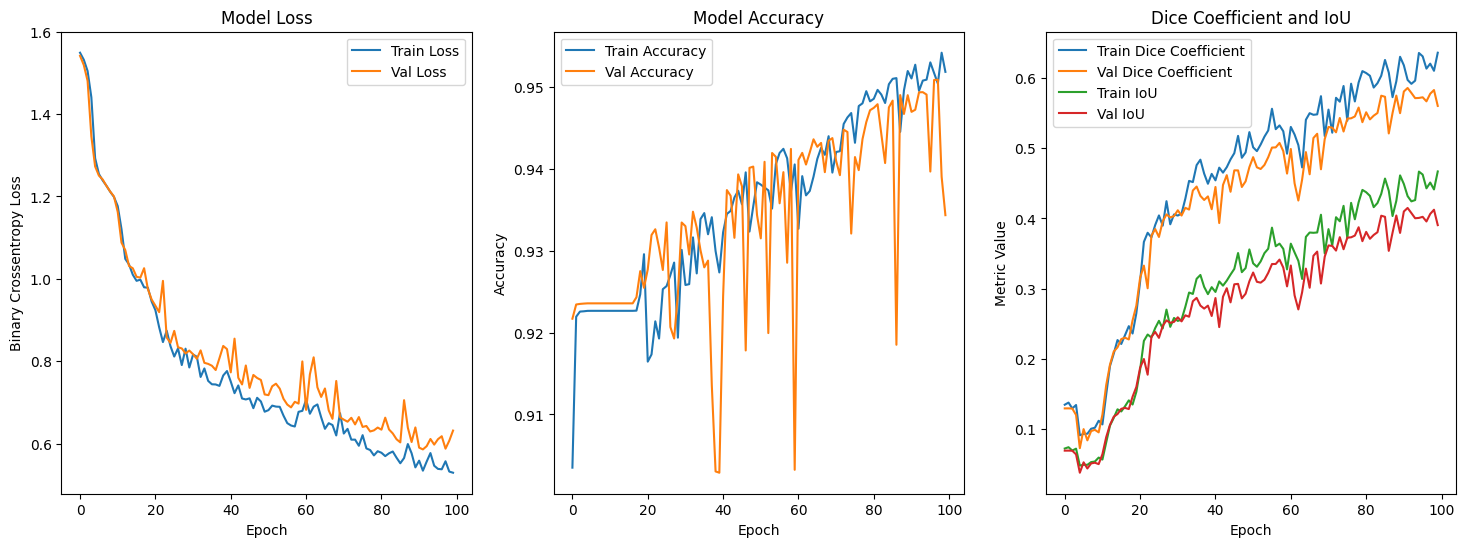

Loaded model weights from /content/models/unet_best_weights.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9491 - dice_coef: 0.6003 - iou_metric: 0.4330 - loss: 0.5718 
Validation Loss: 0.5923178195953369
Validation Accuracy: 0.9472123980522156
Validation Dice Coefficient: 0.5852290987968445
Validation IoU: 0.4181361794471741
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9491 - dice_coef: 0.6003 - iou_metric: 0.4330 - loss: 0.5718 
Evaluation Results:
loss: 0.5923178195953369
compile_metrics: 0.9472123980522156


In [ ]:

# Plot training & validation loss, accuracy, dice coefficient, and IoU
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Binary Crossentropy Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Val Dice Coefficient')
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('Dice Coefficient and IoU')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# Check if the model weights file exists before loading
if os.path.exists(MODEL_SAVE_PATH):
    model.load_weights(MODEL_SAVE_PATH)  # Load the weights only
    print("Loaded model weights from", MODEL_SAVE_PATH)
else:
    print(f"Model weights file not found: {MODEL_SAVE_PATH}")

# Evaluate on validation data
# Unpack all the returned values
loss, accuracy, dice_coef_value, iou_value = model.evaluate(X_val, y_val)

# Print the results
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Dice Coefficient: {dice_coef_value}")
print(f"Validation IoU: {iou_value}")

# Store all returned values in a variable
results = model.evaluate(X_val, y_val)

# Print the results
print("Evaluation Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")


Displays Original image vs predicted mdodel

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


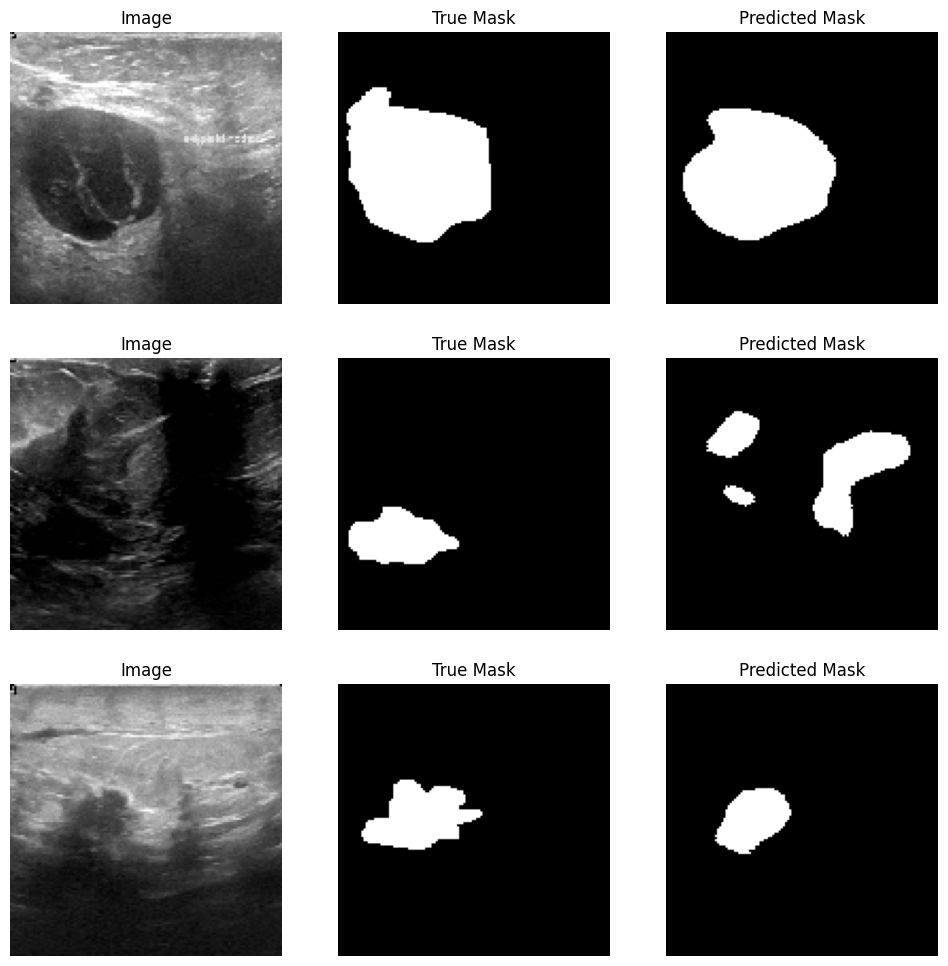

In [ ]:
# Predict on validation data
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)

# Visualize predictions for 3 random samples
def visualize_random_predictions(X, y, preds, num_samples=3):
    # Randomly select indices for the samples
    random_indices = np.random.choice(len(X), num_samples, replace=False)

    plt.figure(figsize=(12, num_samples * 4))
    for i, idx in enumerate(random_indices):
        # Original Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(X[idx])
        plt.title("Image")
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(y[idx].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(preds[idx].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.show()

# Visualize predictions on random validation samples
visualize_random_predictions(X_val, y_val, preds)



Picking a random test image from dataset

Testing on random image: /content/data/img/malignant (197).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


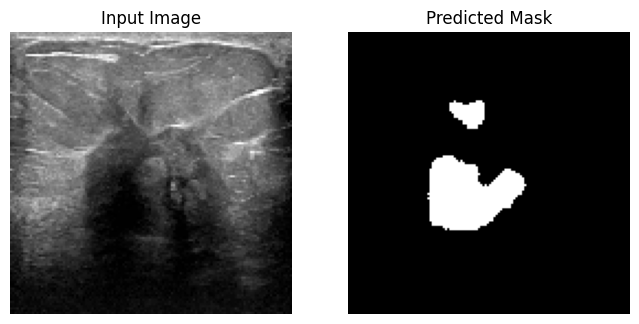

In [ ]:
# Pick a random file from the img folder
def get_random_image(img_folder):
    all_files = os.listdir(img_folder)
    random_file = random.choice(all_files)
    return os.path.join(img_folder, random_file)

# Function to predict on a test image
def predict_on_image(image_path, model, img_height, img_width):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the mask
    pred_mask = model.predict(img_array)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize the mask

    # Display the original image and predicted mask
    plt.figure(figsize=(8, 4))

    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')

    # Display the predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask[0].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()


# Example usage: Predicting on a new test image
img_folder = '/content/data/img'  # Replace with your img folder path
random_test_image = get_random_image(img_folder)

print(f"Testing on random image: {random_test_image}")

predict_on_image(random_test_image, model, IMG_HEIGHT, IMG_WIDTH)
